<a href="https://colab.research.google.com/github/unnxp/AutoPitch/blob/main/AutoPicthModelTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install librosa
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install json

ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [ ]:
import librosa
import librosa.display
import numpy as np
import json
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# โหลด Metadata
metadata_path = "/content/drive/My Drive/dataset/nsynth-train/examples.json"
audio_dir = "/content/drive/My Drive/dataset/nsynth-train/audio"

with open(metadata_path, "r") as f:
    metadata = json.load(f)

# ฟังก์ชันโหลดเสียงและแปลงเป็น Mel-Spectrogram
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalization
    mel_spec_db = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    mel_spec_db = tf.image.resize(mel_spec_db[..., np.newaxis], (128, 128))  # ปรับขนาดเป็น (128,128,1)

    return mel_spec_db, sr



In [ ]:
file_path = "C:/Users/M S I/Desktop/Autopitch/dataset/nsynth-train/audio/vocal_synthetic_015-095-075.wav"
mel_spec, sr = load_audio(file_path)

# แสดง Mel-Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(label="dB")
plt.title("Mel Spectrogram")
plt.show()

In [ ]:
# 🔹 สร้าง Data Generator (เลือก 20000 ข้อมูลแรก)
min_pitch, max_pitch = 0, 127  # MIDI Range
max_samples = 20000  # 🔥 จำกัดข้อมูลที่ 20000 ตัวอย่าง
def data_generator():
    count = 0
    for i, (key, info) in enumerate(metadata.items()):
        if count >= max_samples:
            break  # หยุดเมื่อครบ 20000 ตัวอย่าง

        file_name = key + ".wav"  # 🔹 ใช้ key เป็นชื่อไฟล์
        file_path = os.path.join(audio_dir, file_name)

        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")  # แจ้งเตือนไฟล์หาย
            continue

        mel_spec, _ = load_audio(file_path)
        pitch = info["pitch"]

        if not (min_pitch <= pitch <= max_pitch):
            continue  # ข้ามโน้ตที่อยู่นอกช่วง

        count += 1
        yield mel_spec, pitch - min_pitch  # ✅ Shift pitch ให้เริ่มที่ 0

    print(f"✅ Total samples loaded: {count}")

batch_size = 64
dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),  # ✅ เปลี่ยนเป็น (128,128,1)
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
for mel_batch, pitch_batch in dataset.batch(32).take(1):
    print("Batch shape:", mel_batch.shape, "Pitch shape:", pitch_batch.shape)

In [ ]:
from tensorflow import keras
from keras import layers

input_shape = (128, 128, 1)

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="softmax")  # ✅ 128 คลาส (0-127)
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,592 (619.50 KB)

 Trainable params: 158,592 (619.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ฝึกโมเดลด้วย dataset ที่สร้างไว้
model.fit(dataset, epochs=10)


Epoch 1/10
    296/Unknown 395s 1s/step - accuracy: 0.0181 - loss: 4.5156✅ Total samples loaded: 20000
313/313 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.0194 - loss: 4.5008
Epoch 2/10
296/313 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.1741 - loss: 3.2793✅ Total samples loaded: 20000
313/313 ━━━━━━━━━━━━━━━━━━━━ 318s 965ms/step - accuracy: 0.1775 - loss: 3.2664
Epoch 3/10
296/313 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3541 - loss: 2.5550✅ Total samples loaded: 20000
313/313 ━━━━━━━━━━━━━━━━━━━━ 316s 959ms/step - accuracy: 0.3561 - loss: 2.5481
Epoch 4/10
296/313 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4460 - loss: 2.1992✅ Total samples loaded: 20000
313/313 ━━━━━━━━━━━━━━━━━━━━ 315s 957ms/step - accuracy: 0.4468 - loss: 2.1955
Epoch 5/10
296/313 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5097 - loss: 1.9668✅ Total samples loaded: 20000
313/313 ━━━━━━━━━━━━━━━━━━━━ 315s 956ms/step - accuracy: 0.5101 - loss: 1.9646
Epoch 6/10
296/313 ━━━━━━━━━━━━━━━━━━━━ 16s 9

In [ ]:
# โหลดตัวอย่างเสียงใหม่
test_file = "/content/drive/My Drive/dataset/nsynth-train/audio/vocal_synthetic_012-086-100.wav"
test_mel, _ = load_audio(test_file)

# แปลงเป็น Tensor
test_mel = np.expand_dims(test_mel, axis=(0, -1))  # Reshape เป็น (1, 128, Time, 1)

# ทำนายโน้ต
prediction = model.predict(test_mel)
predicted_pitch = np.argmax(prediction)

print(f"Predicted Pitch: {predicted_pitch}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
Predicted Pitch: 88


In [ ]:
# บันทึกโมเดลหลังจากการฝึก
model.save('/content/drive/My Drive/dataset/MelNoteClassifierV2.h5')


# **ต่อไปจะเป็นการ finetune**

In [ ]:
# กำหนดช่วงข้อมูลที่ต้องการ
start_idx = 20000  # ข้อมูลเริ่มต้นที่ index 20001 (ตัวที่ 20001 คือ index 20000)
end_idx = 50000    # ข้อมูลสิ้นสุดที่ index 50000 (ตัวที่ 50000 คือ index 49999)

def data_generator():
    count = 0
    for i, (key, info) in enumerate(metadata.items()):
        if i < start_idx:
            continue  # ข้ามข้อมูลที่น้อยกว่า 20001

        if i >= end_idx:
            break  # หยุดเมื่อถึงข้อมูลที่ 50000

        file_name = key + ".wav"
        file_path = os.path.join(audio_dir, file_name)

        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            continue

        mel_spec, _ = load_audio(file_path)
        pitch = info["pitch"]

        if not (min_pitch <= pitch <= max_pitch):
            continue

        count += 1
        yield mel_spec, pitch - min_pitch  # Shift pitch ให้เริ่มที่ 0

    print(f"✅ Total samples loaded: {count}")


In [ ]:
from keras.models import load_model

# โหลดโมเดลที่บันทึก
model = load_model('/content/drive/My Drive/dataset/MelNoteClassifier.h5')

In [ ]:
# ทำให้ชั้นก่อนหน้านี้ไม่สามารถฝึกได้
for layer in model.layers[:-2]:  # ปรับเฉพาะ 2 ชั้นสุดท้าย
    layer.trainable = False

# คอมไพล์โมเดลใหม่
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [ ]:
# สร้าง Dataset ใหม่จาก data generator
dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ใช้ ReduceLROnPlateau เพื่อลด learning rate เมื่อ loss ไม่ลดลง
lr_scheduler = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, min_lr=1e-6)

# ฝึกโมเดลด้วย callback
model.fit(dataset, epochs=10, callbacks=[lr_scheduler])

Epoch 1/10
    453/Unknown 755s 2s/step - accuracy: 0.6486 - loss: 1.3999✅ Total samples loaded: 30000
469/469 ━━━━━━━━━━━━━━━━━━━━ 762s 2s/step - accuracy: 0.6489 - loss: 1.3988 - learning_rate: 0.0010
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


453/469 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6701 - loss: 1.3059✅ Total samples loaded: 30000
469/469 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.6701 - loss: 1.3055 - learning_rate: 0.0010
Epoch 3/10
453/469 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6765 - loss: 1.2586✅ Total samples loaded: 30000
469/469 ━━━━━━━━━━━━━━━━━━━━ 697s 1s/step - accuracy: 0.6766 - loss: 1.2582 - learning_rate: 0.0010
Epoch 4/10
453/469 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6855 - loss: 1.2162✅ Total samples loaded: 30000
469/469 ━━━━━━━━━━━━━━━━━━━━ 688s 1s/step - accuracy: 0.6855 - loss: 1.2160 - learning_rate: 0.0010
Epoch 5/10
453/469 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6925 - loss: 1.1821✅ Total samples loaded: 30000
469/469 ━━━━━━━━━━━━━━━━━━━━ 686s 1s/step - accuracy: 0.6925 - loss: 1.1821 - learning_rate: 0.0010
Epoch 6/10
453/469 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6948 - loss: 1.1589✅ Total samples loaded: 30000
469/469 ━━━━━━━━━━━━━━━━━━━━ 704s 1s

In [ ]:
model.save('/content/drive/My Drive/dataset/MelNoteClassifierV2.h5')

In [ ]:
from keras.models import load_model

# โหลดโมเดลที่บันทึก
base_model = load_model('/content/drive/My Drive/dataset/MelNoteClassifierV4.h5')

In [ ]:
for layer in base_model.layers[:-5]:  # Freeze ทุกเลเยอร์ ยกเว้น 5 ชั้นสุดท้าย
    layer.trainable = False
for layer in base_model.layers[-5:]:  # ปลดล็อก 5 ชั้นสุดท้าย
    layer.trainable = True

In [61]:
train_start_idx, train_end_idx = 60000,70000
val_start_idx, val_end_idx = 70000, 78750  # Validation set
test_start_idx, test_end_idx = 78750, 87500  # Test set

def data_generator(start_idx, end_idx):
    count = 0
    for i, (key, info) in enumerate(metadata.items()):
        if i < start_idx:
            continue  # ข้ามข้อมูลที่ไม่ใช้

        if i >= end_idx:
            break  # หยุดเมื่อถึงข้อมูลที่ end_idx

        file_name = key + ".wav"
        file_path = os.path.join(audio_dir, file_name)

        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            continue

        mel_spec, _ = load_audio(file_path)  # โหลดเสียงและแปลงเป็น Mel-Spectrogram
        pitch = info["pitch"]

        count += 1
        yield mel_spec, pitch - min_pitch  # Shift pitch ให้เริ่มที่ 0

    print(f"✅ Total samples loaded: {count}")

# สร้าง Dataset ใหม่จาก data generator

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_start_idx, train_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Validation set
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_start_idx, val_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Test set
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_start_idx, test_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
fine_tune_model = base_model  # ใช้ base_model ที่เทรนไว้แล้ว

# ลด Learning Rate เพื่อ Fine-tune ให้แม่นขึ้น
fine_tune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

In [ ]:
fine_tune_model.fit(train_dataset, epochs=10,validation_data=val_dataset)

Epoch 1/10
    156/Unknown 147s 923ms/step - accuracy: 0.6823 - loss: 1.2648✅ Total samples loaded: 10000
    157/Unknown 151s 945ms/step - accuracy: 0.6823 - loss: 1.2648

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


✅ Total samples loaded: 8750
157/157 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.6823 - loss: 1.2648 - val_accuracy: 0.7016 - val_loss: 1.1765
Epoch 2/10
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.7009 - loss: 1.2075✅ Total samples loaded: 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.7009 - loss: 1.2077✅ Total samples loaded: 8750
157/157 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.7009 - loss: 1.2078 - val_accuracy: 0.7025 - val_loss: 1.1694
Epoch 3/10
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7056 - loss: 1.1904✅ Total samples loaded: 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.7055 - loss: 1.1906✅ Total samples loaded: 8750
157/157 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.7055 - loss: 1.1907 - val_accuracy: 0.7033 - val_loss: 1.1650
Epoch 4/10
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.7092 - loss: 1.1774✅ Total samples loaded: 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0

ประเมินผล

In [ ]:
test_loss, test_acc = fine_tune_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

    136/Unknown 130s 952ms/step - accuracy: 0.7020 - loss: 1.1761✅ Total samples loaded: 8750
137/137 ━━━━━━━━━━━━━━━━━━━━ 130s 951ms/step - accuracy: 0.7021 - loss: 1.1758
Test Accuracy: 0.7070


In [ ]:
model.save('/content/drive/My Drive/dataset/MelNoteClassifierV3.h5')

In [ ]:
from keras.models import load_model

# 1. โหลดโมเดลที่บันทึก (โมเดลที่เทรนไปแล้ว)
base_model = load_model('/content/drive/My Drive/dataset/MelNoteClassifierV2.h5')

In [ ]:
# 2. Freeze เลเยอร์ทั้งหมด ยกเว้น 5 ชั้นสุดท้าย
for layer in base_model.layers[:-5]:  # Freeze ทุกเลเยอร์ ยกเว้น 5 ชั้นสุดท้าย
    layer.trainable = False

for layer in base_model.layers[-5:]:  # ปลดล็อก 5 ชั้นสุดท้าย
    layer.trainable = True

# 3. เตรียมโมเดลสำหรับ fine-tune
# คุณไม่ต้องสร้างโมเดลใหม่เพราะเราใช้ base_model ที่โหลดมาแล้ว
fine_tune_model = base_model

# 4. ลด Learning Rate สำหรับ fine-tune
fine_tune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

# 5. ฝึกโมเดล (Fine-tune) เพิ่ม
history = fine_tune_model.fit(train_dataset,
                    epochs=20,  # เพิ่ม epochs ตามที่ต้องการ
                    validation_data=val_dataset)  # ใช้ validation data



Epoch 1/20
    156/Unknown 154s 966ms/step - accuracy: 0.6823 - loss: 1.2648✅ Total samples loaded: 10000
    157/Unknown 155s 968ms/step - accuracy: 0.6823 - loss: 1.2648✅ Total samples loaded: 8750
157/157 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.6823 - loss: 1.2648 - val_accuracy: 0.7016 - val_loss: 1.1765
Epoch 2/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.7009 - loss: 1.2075✅ Total samples loaded: 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.7009 - loss: 1.2077✅ Total samples loaded: 8750
157/157 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.7009 - loss: 1.2078 - val_accuracy: 0.7025 - val_loss: 1.1694
Epoch 3/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.7056 - loss: 1.1904✅ Total samples loaded: 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.7055 - loss: 1.1906✅ Total samples loaded: 8750
157/157 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.7055 - loss: 1.1907 - val_accuracy: 0.7033 - val_loss: 1.1650
Ep

In [ ]:
fine_tune_model.save('/content/drive/My Drive/dataset/MelNoteClassifierV5.h5')

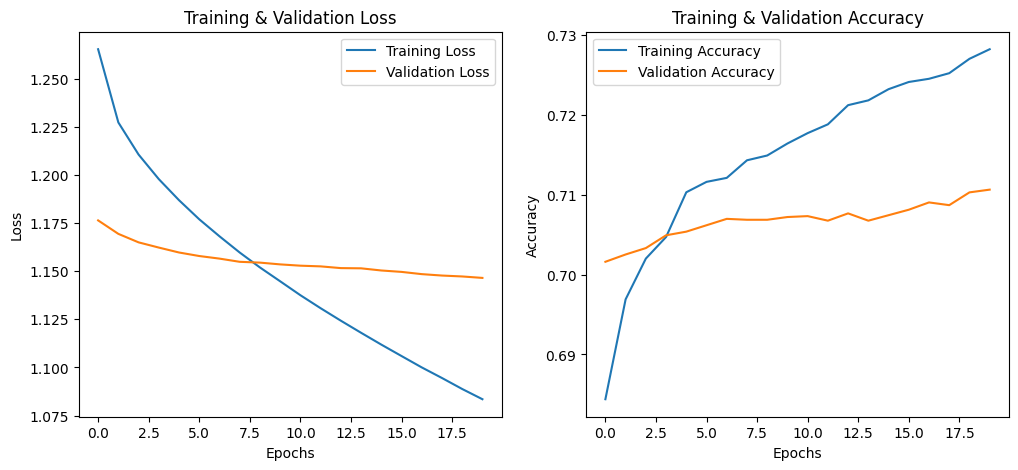

In [ ]:
import matplotlib.pyplot as plt

# พล็อตกราฟ Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# พล็อตกราฟ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [62]:
batch_size = 64

In [65]:
val_start_idx, val_end_idx = 70000, 78750
new_start_idx, new_end_idx = 100044, 110028
test_start_idx, test_end_idx = 78750, 87500
def data_generator(start_idx, end_idx):
    count = 0
    for i, (key, info) in enumerate(metadata.items()):
        if i < start_idx:
            continue  # ข้ามข้อมูลที่ไม่ใช้

        if i >= end_idx:
            break  # หยุดเมื่อถึงข้อมูลที่ end_idx

        file_name = key + ".wav"
        file_path = os.path.join(audio_dir, file_name)

        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            continue

        mel_spec, _ = load_audio(file_path)  # โหลดเสียงและแปลงเป็น Mel-Spectrogram
        pitch = info["pitch"]

        count += 1
        yield mel_spec, pitch - min_pitch  # Shift pitch ให้เริ่มที่ 0

    print(f"✅ Total samples loaded: {count}")

new_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(new_start_idx, new_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Validation set
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_start_idx, val_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Test set
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_start_idx, test_end_idx),
    output_signature=(tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [75]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# โหลดโมเดลที่เทรนไว้แล้ว (สมมุติว่าเป็น Sequential model)
base_model = load_model('/content/drive/My Drive/dataset/MelNoteClassifierV5.h5')
fine_tune_model2 = base_model
# Freeze เลเยอร์: ปลดล็อกเฉพาะ 5 ชั้นสุดท้าย
for layer in base_model.layers[:-5]:
    layer.trainable = False
for layer in base_model.layers[-5:]:
    layer.trainable = True

# สมมุติว่า output ของโมเดลเป็น Dense layer ที่จำแนกจำนวนคลาส

# ลด Learning Rate สำหรับ Fine-tuning
fine_tune_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

# สร้าง Early Stopping Callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# เทรนโมเดล (new_dataset และ val_dataset ต้องถูกเตรียมไว้แล้ว)
history = fine_tune_model2.fit(new_dataset,
                               epochs=20,
                               validation_data=val_dataset,
                               callbacks=[early_stop])


Epoch 1/20
    155/Unknown 139s 882ms/step - accuracy: 0.7204 - loss: 1.1400✅ Total samples loaded: 9984
    156/Unknown 140s 881ms/step - accuracy: 0.7205 - loss: 1.1399

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


✅ Total samples loaded: 8750
156/156 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7205 - loss: 1.1399 - val_accuracy: 0.7123 - val_loss: 1.1228
Epoch 2/20
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.7269 - loss: 1.1133✅ Total samples loaded: 9984
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.7270 - loss: 1.1133✅ Total samples loaded: 8750
156/156 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7270 - loss: 1.1132 - val_accuracy: 0.7120 - val_loss: 1.1206
Epoch 3/20
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.7302 - loss: 1.1014✅ Total samples loaded: 9984
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.7303 - loss: 1.1013✅ Total samples loaded: 8750
156/156 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7303 - loss: 1.1013 - val_accuracy: 0.7129 - val_loss: 1.1187
Epoch 4/20
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.7330 - loss: 1.0908✅ Total samples loaded: 9984
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.73

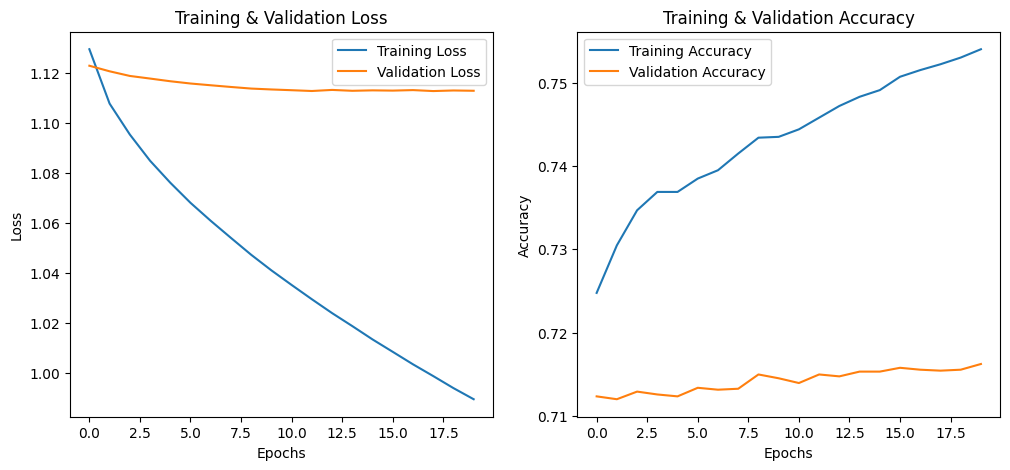

In [68]:
import matplotlib.pyplot as plt

# พล็อตกราฟ Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# พล็อตกราฟ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
base_model.save('/content/drive/My Drive/dataset/MelNoteClassifierV7.h5')